# Topics – Easy Topic Modeling in Python

The text mining technique **Topic Modeling** has become a popular statistical method for clustering documents. This [Jupyter notebook](http://jupyter.org/) introduces a step-by-step workflow, basically containing data preprocessing, the actual topic modeling using **latent Dirichlet allocation** (LDA), which learns the relationships between words, topics, and documents, as well as some interactive visualizations to explore the model.

LDA, introduced in the context of text analysis in [2003](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), is an instance of a more general class of models called **mixed-membership models**. Involving a number of distributions and parameters, the topic model is typically performed using [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) with conjugate priors and is purely based on word frequencies.

There have been written numerous introductions to topic modeling for humanists (e.g. [this one](http://scottbot.net/topic-modeling-for-humanists-a-guided-tour/)), which provide another level of detail regarding its technical and epistemic properties.

For this workflow, you will need a corpus (a set of texts) as plain text (`.txt`) or [TEI XML](http://www.tei-c.org/index.xml) (`.xml`). Using the `dariah_topics` package, you also have the ability to process the output of [DARIAH-DKPro-Wrapper](https://github.com/DARIAH-DE/DARIAH-DKPro-Wrapper), a command-line tool for *natural language processing*.

Topic modeling works best with very large corpora. The [TextGrid Repository](https://textgridrep.org/) is a great place to start searching for text data. Anyway, to demonstrate the technique, we provide one small text collection in the folder `grenzboten_sample` containing 15 diary excerpts, as well as 15 war diary excerpts, which appeared in *Die Grenzboten*, a German newspaper of the late 19th and early 20th century.

**Of course, you can work with your own corpus in this notebook.**

We're relying on the LDA implementation by [Andrew McCallum](https://people.cs.umass.edu/~mccallum/), called [MALLET](http://mallet.cs.umass.edu/topics.php), which is known to be very robust. Aside from that, we provide two more Jupyter notebooks:

* [IntroducingGensim](IntroducingGensim.ipynb), using LDA by [Gensim](https://radimrehurek.com/project/gensim/), which is attractive because of its multi-core support.
* [IntroducingLda](IntroducingLda.ipynb), using LDA by [lda](http://pythonhosted.org/lda/index.html), which is very lightweight.

For more information in general, have a look at the [documentation](http://dev.digital-humanities.de/ci/job/DARIAH-Topics/doclinks/1/).

## First step: Installing dependencies

To work within this Jupyter notebook, you will have to import the `dariah_topics` library. As you do, `dariah_topics` also imports a couple of external libraries, which have to be installed first. `pip` is the preferred installer program in Python. Starting with Python 3.4, it is included by default with the Python binary installers. If you are interested in `pip`, have a look at [this website](https://docs.python.org/3/installing/index.html).

To install the `dariah_topics` library with all dependencies, open your commandline, go with `cd` to the folder `Topics` and run:

```
pip install -r requirements.txt
```

Alternatively, you can do:

```
python setup.py install
```

If you get any errors or are not able to install *all* dependencies properly, try [Stack Overflow](https://stackoverflow.com/questions/tagged/pip) for troubleshooting or create a new issue on our [GitHub page](https://github.com/DARIAH-DE/Topics).

**Important**: If you are on macOS or Linux, you will have to use `pip3` and `python3`.

### Some final words
As you already know, code has to be written in the grey cells. You execute a cell by clicking the **Run**-button. If you want to run all cells of the notebook at once, click **Cell > Run All** or **Kernel > Restart & Run All** respectively, if you want to restart the Python kernel first. On the left side of an (unexecuted) cell stands `In [ ]:`. The empty bracket means, that the cell hasn't been executed yet. By clicking **Run**, a star appears in the brackets (`In [*]:`), which means the process is running. In most cases, you won't see that star, because your computer is faster than your eyes. You can execute only one cell at once, all following executions will be in the waiting line. If the process of a cell is done, a number appears in the brackets (`In [1]:`).

## Starting with topic modeling!

Execute the following cell to import modules from the `dariah_topics` library.

In [1]:
from dariah_topics import preprocessing
from dariah_topics import meta
from dariah_topics import mallet
from dariah_topics import postprocessing
from dariah_topics import visualization

Let's not pay heed to any warnings right now and execute the following cell.

In [2]:
import warnings
warnings.filterwarnings('ignore')

The following line will just tell the notebook to show graphics in the output frames.

In [3]:
%matplotlib inline

## 1. Preprocessing

### 1.1. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using the 30 diary excerpts from the folder `grenzboten`. To use your own corpus, change the path accordingly.

In [4]:
path_to_corpus = 'grenzboten_sample/*.txt'

By adding `/*.txt` to the actual path, we make sure to select only files with the suffix `.txt`.

#### Accessing file paths and metadata
We begin by creating a list of all the documents in the folder specified above. That list will tell the function `preprocessing.read_from_pathlist` (see below) which text documents to read. Furthermore, based on filenames we can create some metadata, e.g. author and title.

In [5]:
metadata = meta.fn2metadata(path_to_corpus)
metadata[:5] # by adding '[:5]' to the variable, only the first 5 elements will be printed

,author,basename,filename,title
0,Beck,Beck_1844_Tagebuch_56,grenzboten_sample/Beck_1844_Tagebuch_56.txt,1844_Tagebuch_56
1,Unbekannt,Unbekannt_1844_Tagebuch_70,grenzboten_sample/Unbekannt_1844_Tagebuch_70.txt,1844_Tagebuch_70
2,Nimmer,Nimmer_1844_Tagebuch_77,grenzboten_sample/Nimmer_1844_Tagebuch_77.txt,1844_Tagebuch_77
3,Unbekannt,Unbekannt_1844_Tagebuch_82,grenzboten_sample/Unbekannt_1844_Tagebuch_82.txt,1844_Tagebuch_82
4,Jörgel,Jörgel_1844_Tagebuch_88,grenzboten_sample/Jörgel_1844_Tagebuch_88.txt,1844_Tagebuch_88


#### Read listed documents from folder

In [6]:
corpus = list(preprocessing.read_from_pathlist(metadata['filename']))
corpus[0][:255] # printing the first 255 characters of the first document

'Tagebuch von Karl Beck. Man spricht seit vierzehn Tagen von einem vollständigen Ministerwechsel und es circuliren im Publicum die verschiedensten Combinationen, wobei heute ganz andere Namen genannt werden, als gestern und morgen wieder andere, als heute.'

Your `corpus` contains as much elements (`documents`) as texts in your corpus are. Each element of `corpus` is a list containing exactly one element, the text itself as one single string including all whitespaces and punctuations:

```
[['This is the content of your first document.'],
 ['This is the content of your second document.'],
 ...
 ['This is the content of your last document.']]
```

### 1.3. Tokenize corpus
Now, your `documents` in `corpus` will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function `dariah_topics` provides is a simple Unicode tokenizer. Depending on the corpus, it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [7]:
tokenized_corpus = [list(preprocessing.tokenize(document)) for document in corpus]

At this point, each `document` is represented by a list of separate token strings. As above, have a look at the first document (which has the index `0` as Python starts counting at 0) and show its first 14 words/tokens (that have the indices `0:13` accordingly).

In [8]:
tokenized_corpus[0][0:13]

['tagebuch',
 'von',
 'karl',
 'beck',
 'man',
 'spricht',
 'seit',
 'vierzehn',
 'tagen',
 'von',
 'einem',
 'vollständigen',
 'ministerwechsel']

### 1.4 Create a document-term matrix

The LDA topic model is based on a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) of the corpus. To improve performance in large corpora, the matrix describes the frequency of terms that occur in the collection. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

#### 1.4.1 Large corpus matrix

If you have a very large corpus, create a document-term matrix designed for large corpora.

In [9]:
document_term_matrix, document_ids, type_ids = preprocessing.create_document_term_matrix(tokenized_corpus, metadata['title'], large_corpus=True)

#### 1.4.2 Small corpus matrix

Otherwise, use the document-term matrix desigend for small corpora.

In [10]:
document_term_matrix = preprocessing.create_document_term_matrix(tokenized_corpus, metadata['title'])
document_term_matrix[:5]

,die,der,und,in,den,von,zu,das,des,nicht,...,staatsmonopol,steigernde,staatspapieren,staatsrücksichten,staatszeitung,stallknecht,stammen,starkem,statu,subscriben
1844_Tagebuch_56,90.0,92.0,84.0,70.0,30.0,26.0,25.0,16.0,25.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_70,205.0,224.0,193.0,133.0,78.0,64.0,112.0,86.0,45.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_77,181.0,153.0,141.0,98.0,55.0,59.0,72.0,59.0,44.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_82,213.0,207.0,169.0,128.0,85.0,86.0,79.0,80.0,66.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844_Tagebuch_88,68.0,59.0,70.0,54.0,22.0,27.0,28.0,19.0,13.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5. Feature removal

*Stopwords* (also known as *most frequent tokens*) and *hapax legomena* are harmful for LDA and have to be removed from the corpus or the document-term matrix respectively. In this example, the 50 most frequent tokens will be categorized as stopwords.

**Hint**: Be careful with removing most frequent tokens, you might remove tokens quite important for LDA. Anyway, to gain better results, it is highly recommended to use an external stopwords list.

In this notebook, we combine the 50 most frequent tokens, hapax legomena and an external stopwordslist.

#### List the 100 most frequent words

If you have chosen the large corpus model, you will have to add `type_ids` to the function `preprocessing.find_stopwords()`.

In [11]:
stopwords = preprocessing.find_stopwords(document_term_matrix, most_frequent_tokens=100)

These are the five most frequent words:

In [12]:
stopwords[:5]

['die', 'der', 'und', 'in', 'den']

#### List hapax legomena

In [13]:
hapax_legomena = preprocessing.find_hapax_legomena(document_term_matrix)
print("Total number of types in corpus:", document_term_matrix.shape[1])
print("Total number of hapax legomena:", len(hapax_legomena))

Total number of types in corpus: 24451
Total number of hapax legomena: 19757


#### Optional: Use external stopwordlist

In [14]:
path_to_stopwordlist = "tutorial_supplementals/stopwords/de.txt"
external_stopwords = [line.strip() for line in open(path_to_stopwordlist, 'r', encoding='utf-8')]

#### Combine lists and remove content from `tokenized_corpus`

In [15]:
features = stopwords + hapax_legomena + external_stopwords
clean_tokenized_corpus = list(preprocessing.remove_features(features, tokenized_corpus=tokenized_corpus))

## 2. Model creation

#### Path to MALLET folder 

Now we must tell the library where to find the local instance of MALLET. If you managed to install MALLET, it is sufficient set `path_to_mallet = 'mallet'`, if you store MALLET in a local folder, you have to specify the path to the binary explictly (e.g. `path_to_mallet = 'C:/mallet-2.0.8/bin/mallet'`).

**Whitespaces are not allowed in the path!**

In [16]:
path_to_mallet = "mallet"

### 2.1. Create `Mallet` object

Finally, we can instance the `Mallet` object.

In [17]:
Mallet = mallet.Mallet(path_to_mallet)

The object `Mallet` has a method `import_tokenized_corpus()` to create a specific corpus file for MALLET.

In [18]:
mallet_corpus = Mallet.import_tokenized_corpus(clean_tokenized_corpus, metadata['basename'])

Furthermore, `Mallet` has the method `train_topics()` to create and train the LDA model. To create a LDA model, there have to be specified a couple of parameters.

But first, if you are curious about any library, module, class or function, try `help()`. This can be very useful, because (at least in a well documented library) explanations of use and parameters will be printed. We're interested in the function `Mallet.train_topics()` in the module `dariah_topics.mallet`, so let's try:

```
help(mallet.create_mallet_model)
```

This will print something like this (in fact even more):

```
Help on method train_topics in module dariah_topics.mallet:

train_topics(mallet_binary, **kwargs) method of dariah_topics.mallet.Mallet instance
    Args:
        input_model (str): Absolute path to the binary topic model created by `output_model`.
        output_model (str): Write a serialized MALLET topic trainer object.
            This type of output is appropriate for pausing and restarting training,
            but does not produce data that can easily be analyzed.
        output_topic_keys (str): Write the top words for each topic and any
            Dirichlet parameters to file.
        topic_word_weights_file (str): Write unnormalized weights for every
            topic and word type.
        word_topic_counts_file (str): Write a sparse representation of topic-word
            assignments. By default this is null, indicating that no file will
            be written.
        output_doc_topics (str): Write the topic proportions per document, at
            the end of the iterations.
        num_topics (int): Number of topics. Defaults to 10.
        num_top_words (int): Number of keywords for each topic. Defaults to 10.
        num_interations (int): Number of iterations. Defaults to 1000.
        num_threads (int): Number of threads for parallel training.  Defaults to 1.
        num_icm_iterations (int): Number of iterations of iterated conditional
            modes (topic maximization).  Defaults to 0.
        no_inference (bool): Load a saved model and create a report. Equivalent
            to `num_iterations = 0`. Defaults to False.
        random_seed (int): Random seed for the Gibbs sampler. Defaults to 0.
        optimize_interval (int): Number of iterations between reestimating
            dirichlet hyperparameters. Defaults to 0.
        optimize_burn_in (int): Number of iterations to run before first
            estimating dirichlet hyperparameters. Defaults to 200.
        use_symmetric_alpha (bool): Only optimize the concentration parameter of
            the prior over document-topic distributions. This may reduce the
            number of very small, poorly estimated topics, but may disperse common
            words over several topics. Defaults to False.
        alpha (float): Sum over topics of smoothing over doc-topic distributions.
            alpha_k = [this value] / [num topics]. Defaults to 5.0.
        beta (float): Smoothing parameter for each topic-word. Defaults to 0.01.
```

So, now you know how to define the number of topics and the number of sampling iterations as well. A higher number of iterations will probably yield a better model, but also increases processing time. `alpha` and `beta` are so-called *hyperparameters*. They influence the model's performance, so feel free to play around with them. In the present example, we will leave the default values. Furthermore, there exist various methods for hyperparameter optimization, e.g. gridsearch or Gaussian optimization.

**Warning: This step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of iterations. Our example corpus should be done within a minute or two at `num_iterations=5000`.

In [19]:
%%time

Mallet.train_topics(mallet_corpus,
                    output_topic_keys='tutorial_supplementals/mallet_output/topic_keys.txt',
                    output_doc_topics='tutorial_supplementals/mallet_output/doc_topics.txt',
                    num_topics=10,
                    num_iterations=1000)

CPU times: user 2.93 ms, sys: 12.1 ms, total: 15 ms
Wall time: 5.63 s


### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas data frame) that constitutes our principle exchange format for topic modeling results. For generating the matrix from a Gensim model, we can use the following function:

In [20]:
topics = postprocessing.show_topics(topic_keys_file='tutorial_supplementals/mallet_output/topics.txt')
topics

,Key 0,Key 1,Key 2,Key 3,Key 4,Key 5,Key 6,Key 7,Key 8,Key 9,Key 10,Key 11,Key 12,Key 13,Key 14,Key 15,Key 16,Key 17,Key 18,Key 19
Topic 0,geschichte,geben,hiesigen,gehört,politik,österreichischen,männer,wissen,oesterreich,himmel,eisenbahn,landes,erzherzog,musik,kinder,censur,that,leben,verhältnisse,poesie
Topic 1,märz,april,englischen,kriegstagebuch,östlich,dezember,versenkt,türken,starke,maas,heftige,gestürmt,englische,flugzeuge,grenzboten,schweren,russischen,stellung,erfolg,englischer
Topic 2,frankreich,lassen,finden,sagen,regierung,weise,presse,preußen,welt,steht,sogar,sprache,berliner,leipzig,namentlich,schreiben,trotz,professor,halten,bringen
Topic 3,südöstlich,polizei,italienischen,monte,druck,graf,deutsches,verlag,feinde,leser,london,italien,eigentlich,hundert,erscheint,beute,greifen,weder,verlassen,gegenwärtig
Topic 4,deutschland,zeitung,könig,wiener,gesellschaft,interesse,fast,zeitungen,frage,artikel,meisten,kunst,junge,lassen,rede,belgien,kennen,stelle,beobachter,redacteur
Topic 5,franzosen,italiener,höhe,feind,rußland,genommen,erfolgreiche,gescheitert,französischen,geschlagen,stadt,zurückgeworfen,adresse,vernichtet,öffentlichen,erfolgreicher,dame,kilometer,geworfen,herausgeber
Topic 6,september,england,weiß,theil,gebracht,fremden,sehen,ließ,höchst,journal,preußischen,politischen,thun,öffentliche,bezug,alten,iii,zukunft,worte,nehmen
Topic 7,glauben,seite,ward,berlin,scheint,publicum,wien,volk,stadt,oesterreich,gegeben,seiten,guten,dichter,briefe,könnten,armen,stände,theater,mal
Topic 8,abgewiesen,geschütze,südlich,januar,juli,nördlich,genommen,feindliche,abgeschlagen,westlich,stellungen,englische,angriff,mehrere,verlusten,offiziere,truppen,kämpfe,august,italienische
Topic 9,art,gewiß,deutscher,kaiser,denken,fand,leben,letzten,namen,literatur,stande,mitglieder,polen,erscheinen,stets,minister,bleibt,bekanntlich,stellen,deutschland


## 3. Visualization

Now we can see the topics in the model with the following function:

**Hint:** Depending on the number of topics chosen in step 2, you might have to adjust *num_topics* in this step accordingly.

In [21]:
document_topics = postprocessing.show_document_topics(topics=topics,
                                                      doc_topics_file='tutorial_supplementals/mallet_output/document_topics.txt')
document_topics[:5]

,Unbekannt_1845_Tagebuch_85,Trepow_1914_Kriegstagebuch_68,Ferdinand_1846_Tagebuch_72,Lützo_1914_Kriegstagebuch_97,Weber_1916_Kriegstagebuch_81,Wickenburg_1845_Tagebuch_62,Unbekannt_1844_Tagebuch_82,Nimmer_1844_Tagebuch_77,Uliwud_1914_Kriegstagebuch_95,Kader_1846_Tagebuch_82,...,Berto_1915_Kriegstagebuch_94,Zedlitz_1845_Tagebuch_81,Lutz_1915_Kriegstagebuch_39,Lacratelle_1845_Tagebuch_93,Jörgel_1844_Tagebuch_88,Unbekannt_1846_Tagebuch_96,Lützo_1915_Kriegstagebuch_73,Unbekannt_1844_Tagebuch_70,Unbekannt_1846_Tagebuch_88,Cleinom_1914_Kriegstagebuch_94
geschichte geben hiesigen,0.116334,0.012821,0.116731,0.034562,0.008844,0.122586,0.082566,0.093727,0.024893,0.128886,...,0.008333,0.125366,0.011381,0.110208,0.118117,0.122593,0.009677,0.092780,0.126635,0.021411
märz april englischen,0.020221,0.189459,0.028382,0.223502,0.231973,0.031384,0.028618,0.020538,0.288051,0.031325,...,0.241667,0.016953,0.204097,0.020481,0.013321,0.034938,0.229032,0.030716,0.001784,0.190176
frankreich lassen finden,0.154149,0.024217,0.183312,0.025346,0.002041,0.178380,0.176645,0.158701,0.033428,0.219751,...,0.001667,0.153830,0.000759,0.168075,0.251332,0.196914,0.001075,0.180811,0.184899,0.011335
südöstlich polizei italienischen,0.090599,0.118234,0.066368,0.066820,0.090476,0.103273,0.078618,0.107916,0.076102,0.071975,...,0.025000,0.075136,0.081184,0.078999,0.077265,0.040123,0.061290,0.049082,0.096908,0.094458
deutschland zeitung könig,0.110032,0.024217,0.162825,0.016129,0.012925,0.102200,0.149013,0.132562,0.049075,0.138929,...,0.001667,0.189410,0.003794,0.208388,0.199822,0.163827,0.011828,0.182077,0.094530,0.026448


### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in a heat map.

In [22]:
from bokeh.io import show

plot = visualization.doc_topic_heatmap_interactive(document_topics, title='Grenzboten')
show(plot, notebook_handle=True)

Loading BokehJS ...

#### Distribution of topics in a single documents

To take closer look on the topics in a single text, we can use the follwing function that shows all the topics in a text and their respective proportions. To select the document, we have to give its index to the function.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

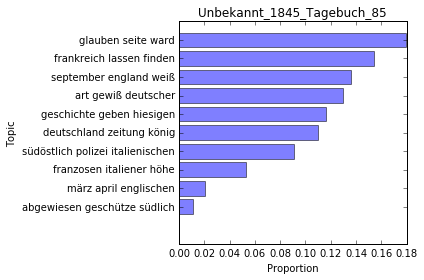

In [23]:
visualization.plot_doc_topics(document_topics, 0)